# DESIGN OF EXPERIMENTS

This notebook describes the computations needed to do a 1-Way Design.

# Overview

This lecture illustrates a workflow for developing codes that run studies to do a one-factor-at-a-time (OFT) experimental design.
The running example is the model of glycolytic oscillations developed in J. Wolf et al., Biochem., 2000.

The function ``runStudy`` encapsulates the full workflow. This consists of:
1. running simulations for the factors and levels to be studied
1. calculating response values from the simulation results
1. constructing a table (dataframe) that reports the responses $y$ by factor level
1. calculating the $\mu$, $\alpha$ for design of experiments

The notebook contains codes for (1)-(3) for the Wolf model.
Responses are the oscillation frequency for glucose.

# Preliminaries

In [51]:
IS_COLAB = True

In [52]:
# Code installs. Only needed once.
if IS_COLAB:
    !pip install -q tellurium
    pass

In [53]:
import urllib.request
def getSharedCodes(moduleName):
  """
  Obtains common codes from the github repository.

  Parameters
  ----------
  moduleName: str
      name of the python module in the src directory
  """
  if IS_COLAB:
      url = "https://github.com/sys-bio/network-modeling-summer-school-2021/raw/main/src/%s.py" % moduleName
      local_python = "python.py"
      _, _ = urllib.request.urlretrieve(url=url, filename=local_python)
  else:
      local_python = "../../src/%s.py" % moduleName
  with open(local_python, "r") as fd:
    codeStr = "".join(fd.readlines())
  print(codeStr)
  exec(codeStr, globals())

# Acquire codes
getSharedCodes("util")

# TESTS
assert(isinstance(LINEAR_PATHWAY_DF, pd.DataFrame))

import pandas as pd
import urllib.request

# Linear pathway data
BASE_URL = "https://github.com/sys-bio/network-modeling-summer-school-2021/raw/main/"
BASE_DATA_URL = "%sdata/" % BASE_URL
BASE_MODULE_URL = "%ssrc/" % BASE_URL
BASE_MODEL_URL = "%smodels/" % BASE_URL
LOCAL_FILE = "local_file.txt"


def getData(csvFilename):
    """
    Creates a dataframe from a CSV structured URL file.

    Parameters
    ----------
    csvFilename: str
        Name of the CSV file (w/o ".csv" extension)

    Returns
    -------
    pd.DataFrame
    """
    url = "%s%s.csv" % (BASE_DATA_URL, csvFilename)
    filename, _ = urllib.request.urlretrieve(url, filename=LOCAL_FILE)
    return pd.read_csv(LOCAL_FILE)

def getModule(moduleName):
    """
    Obtains common codes from the github repository.
  
    Parameters
    ----------
    moduleName: str
        name of the python module in the src directory
    """
    url = "%s%s.py" % (BASE_MODULE_URL, moduleName)
    _, _ = urllib.request.urlretrieve(url, 

In [54]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy import fftpack
import tellurium as te

In [55]:
# Constants
AMPLIDX = 1  # Index of amplitude values
FONTSIZE = 16
FREQIDX = 0  # Index of frequency values
TIME = "time"
SMALLEST_PCT = -100  # Smallest percent change in a parameter value

# Wolf Model

We begin with an exploration of the Wolf model to understand its parameters and to determine what responses should be reported by an experiment.

## Constants for Model

In [56]:
print(WOLF_MODEL)

// Created by libAntimony v2.12.0.3
model *Jana_WolfGlycolysis()

  // Compartments and Species:
  compartment compartment_;
  species Glucose in compartment_, fructose_1_6_bisphosphate in compartment_;
  species glyceraldehyde_3_phosphate in compartment_, glycerate_3_phosphate in compartment_;
  species pyruvate in compartment_, Acetyladehyde in compartment_, External_acetaldehyde in compartment_;
  species ATP in compartment_, ADP in compartment_, NAD in compartment_, NADH in compartment_;
  species $External_glucose in compartment_, $ethanol in compartment_, $Glycerol in compartment_;
  species $Sink in compartment_;

  // Reactions:
  J0: $External_glucose => Glucose; J0_inputFlux;
  J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP; J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n));
  J2: fructose_1_6_bisphosphate => glyceraldehyde_3_phosphate + glyceraldehyde_3_phosphate; J2_k*fructose_1_6_bisphosphate;
  J3: glyceraldehyde_3_phosphate + NADH => NAD + $Glycerol; J3_k*glyceralde

In [57]:
# Constants used in the analysis of the Wolf model
START = 0
END = 5
NUMPT = 300  # number of points to simulate
WOLF_FACTORS = [
  "J0_inputFlux", "J1_k1", "J1_Ki", "J1_n", "J2_k", "J3_k", "J4_kg", "J4_kp",
 "J4_ka", "J4_kk", "J5_k", "J6_k", "J7_k", "J8_k1", "J8_k2", "J9_k", "J10_k",     
]

## Exploration of the Model

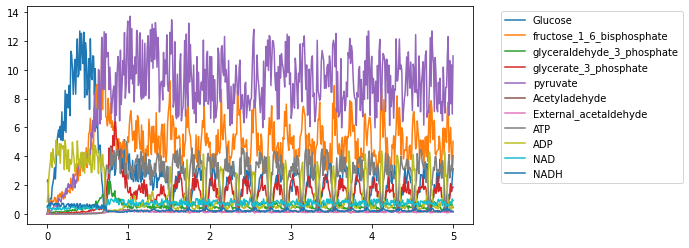

In [58]:
def timePlots(data=WOLF_ARR, title=""):
    fig, ax = plt.subplots(1, figsize=(8, 4))
    colnames = WOLF_DF.columns
    p = ax.plot(data[:, 0], data[:,1:])
    _ = ax.legend(p, colnames[1:], bbox_to_anchor=(1.05, 1), loc='upper left')
    _ = ax.set_title(title)
timePlots()

# Planning the Study

1. What are the research questions? In this study, we want to understand how the kinetic contants affect oscillations.
2. What are the factors and levels? The factors are the kinetic constants. The levels are percentage changes in the values of the contants compared with the baseline.
1. What are the responses? We calculate the Fast Fourier Transform (FFT) to obtain pairs of frequency and amplitude (the fourier coefficient).

# Running Simulations With Changes in Parameter Values

The first thing we need to do is to be able to run an experiment when a parameter is changed.
We consider multiple levels for the parameter value.

In [59]:
def runSimulations(parameter, percents, isPlot=True):
    """
    Runs experiments and produces plots for the fractional changes in parameter values.

    Parameters
    ----------
    parameter: str
    percents: list-float
        list of percent change in values
          (smallest value is -100)
          
    Returns
    -------
    dict: key=pct, value=data
    """
    roadrunner = te.loada(WOLF_MODEL)
    baseValue = roadrunner[parameter]
    if not parameter in roadrunner.keys():
        raise ValueError("Unknown parameter name: %s" % parameter)
    resultDct = {}
    for percent in percents:
        roadrunner.resetAll()
        percent = max(percent, SMALLEST_PCT)
        frac = 0.01*percent
        newValue = baseValue*(1 + frac)
        roadrunner[parameter] = newValue
        data = roadrunner.simulate(START, END, NUMPT)
        title = "%s: %f (%d%%)" % (parameter, newValue, percent)
        resultDct[percent] = data
        if isPlot:
            timePlots(data=data, title=title)
    return resultDct

# Tests
percents = [-10, 0, 10]
resultDct = runSimulations("J1_Ki", percents, isPlot=False)
assert(len(set(percents).symmetric_difference(resultDct.keys())) == 0)

Here's an example of using these codes.

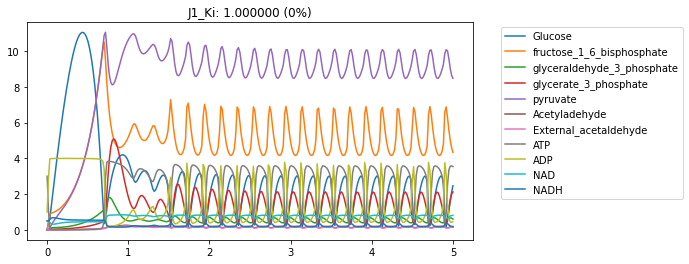

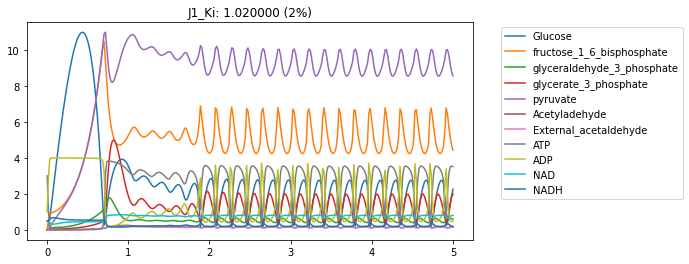

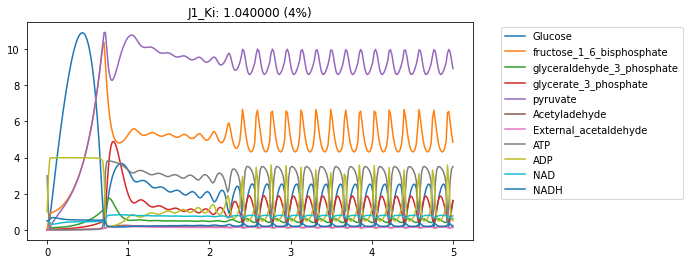

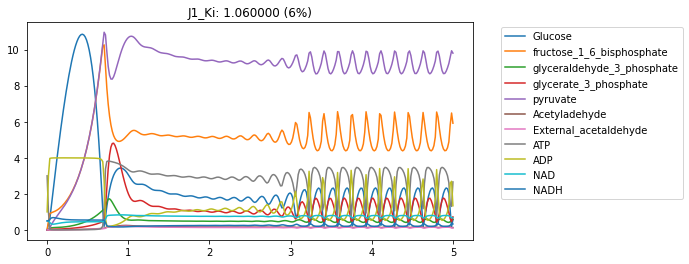

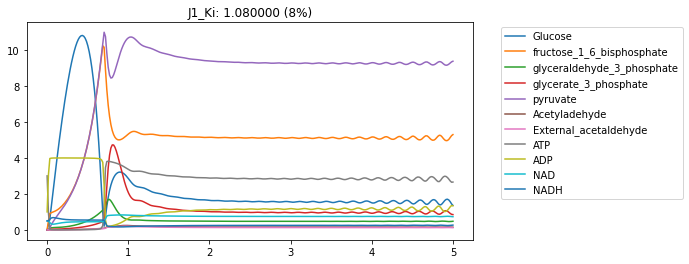

In [60]:
# Experiments 
changes = 2*np.array(range(5))
length = len(changes)
_ = runSimulations("J1_Ki", changes)

**Questions**
1. What happens when J1_Ki is reduced?
1. Do other parameters behave in a similar way in that the onset of cyclic behavior is delayed with a larger change?
1. What metric(s) should we use to quantify the effect on cyclic behavior?

# Calculating Responses

One way to quantify the response to changes in parameters is to use the Fast Fourier Transform (FFT).
This section develops codes that calculate responses.

In [61]:
def calculateFft(molecule, data, offset=100):
    """
    Calculate the FFT for a molecule in the simulation output.
    The calculation does not include amplitudes at a frequency of 0.
    
    Parameters
    ----------
    molecule: str
    data: NamedArray/DataFrame
    offset: int
        Initial data that are not included in the FFT calculation
             
    Returns
    -------
    list-float, list-float
        freqs, fftValues
    """
    # Returns frequencies and abs(fft) for a chemical species (molecule)
    if isinstance(data, pd.DataFrame):
        data = data.copy()
        colnames = ["[" + c + "]" for c in data.columns]
        data.columns = colnames
        times = np.array(list(data.index))
    else:
        times = data["time"]
    col = "[%s]" % molecule
    values = np.array(list(data[col]))
    numPoint = len(data)
    count = numPoint - offset
    endTime = times[-1]
    freqs = fftpack.fftfreq(count, endTime/numPoint)
    fftValues = np.abs(fftpack.fft(values[offset:]))
    # Eliminate frequency of 0
    freqs = freqs[1:]
    fftValues = fftValues[1:]
    return freqs, fftValues

# Tests
freqs, fftValues = calculateFft("Glucose", WOLF_DF)
assert(max(fftValues) > 90)  # Top frequency should have a large magnitude

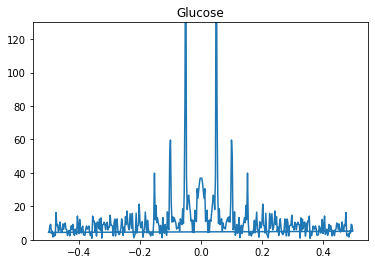

In [62]:
def plotFft(molecule, data=WOLF_DF, ax=None, **kwargs):
    """
    Plot the FFT for a molecule.
    
    Parameters
    ----------
    data: NamedArray
    ax: Matplotlib.Axes
    kwargs: dict
        optional arguments passed to FFT calculation
    """
    if ax is None:
        _, ax = plt.subplots(1,1)
    freqs, fftValues = calculateFft(molecule, data=data, **kwargs)
    ax.plot(freqs, fftValues)
    ax.set_title(molecule)
    ax.set_ylim([0, 130])
    
# Tests
plotFft("Glucose")  # "Smoke" test

In [63]:
def calculatePeakFrequency(molecule, data, numDelete=0, offset=100):
    """
    Calculate the FFT for a molecule in the simulation output.
    The calculation does not include amplitudes at a frequency of 0.
    
    Parameters
    ----------
    molecule: str
    data: NamedArray/DataFrame
    offset: int
        Initial data that are not included in the FFT calculation
             
    Returns
    -------
    float: peak frequency
    """
    def getIndexOfMax(arr):
        maxx = max(arr)
        lst = list(arr)
        return lst.index(maxx)
    def deleteArrayElement(arr, idx):
        lst = list(arr)
        lst1 = lst[:idx]
        lst2 = lst[idx+1:]
        newLst = lst1.extend(lst2)
        return np.array(lst1)    
    #
    frequencies, amplitudes = calculateFft(molecule, data)
    # Delete the largest N values
    for _ in range(numDelete):
        maxIdx = getIndexOfMax(amplitudes)
        frequencies = deleteArrayElement(frequencies, maxIdx)
        amplitudes = deleteArrayElement(amplitudes, maxIdx)
    # Report the next highest value
    maxIdx = getIndexOfMax(amplitudes)
    return frequencies[maxIdx]

# TESTS
assert(calculatePeakFrequency("Glucose", WOLF_DF) > 0)

# Calculate Responses

In [64]:
def calculateFrequencyResponses(factors=WOLF_FACTORS, percents=[0], molecule="Glucose"):
    """
    Calculates the frequency responses for a 1WD for the factors and 
    levels expressed as percents.

    Parameters
    ----------
    factors: list-str (kinetic constants)
    percents: float

    Returns
    -------
    pd.DataFrame
       rows: factor
       columns: percents
       values: frequency
    """
    percentDct = {p: [] for p in percents}
    for factor in factors:
        dataDct = runSimulations(factor, percents, isPlot=False)
        # Calculate the FFT for all percents for this factor
        for percent in dataDct.keys():
            frequency = calculatePeakFrequency(molecule, dataDct[percent])
            percentDct[percent].append(frequency)
    return pd.DataFrame(percentDct, index=factors)

df = calculateFrequencyResponses(percents=[-2, 0, 2])
assert(isinstance(df, pd.DataFrame))

In [65]:
PERCENTS = [-20, -10, -5, -2, 0, 2, 5, 10, 20]
RESPONSE_DF = calculateFrequencyResponses(percents=PERCENTS)
RESPONSE_DF

,-20,-10,-5,-2,0,2,5,10,20
J0_inputFlux,7.5,6.3,5.7,5.4,5.1,4.8,4.5,4.5,0.3
J1_k1,4.5,4.8,4.8,5.1,5.1,5.1,5.1,5.4,5.7
J1_Ki,3.0,3.9,4.5,4.8,5.1,5.4,5.7,0.3,0.3
J1_n,0.3,0.3,0.3,5.4,5.1,4.8,4.5,3.9,3.0
J2_k,4.8,4.8,5.1,5.1,5.1,5.1,5.1,5.1,5.4
J3_k,4.8,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1
J4_kg,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1
J4_kp,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1
J4_ka,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1
J4_kk,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1


**Questions**
1. Which parameters show an effect on frequency for the levels considered?
1. Of these, which parameter values are inversely related to frequency?

# Calculating $\mu$, $\alpha$

$\mu$ is the baseline for the simulation.
$\alpha_{i, k_i} = y_{i, k_i} - \mu$

In [66]:
def calculateMuAlpha(responseDF):
    """
    Calculates the design of experiment parameters for a 1-Way Design.
    Assumes that there is a level of 0.

    Parameters
    ----------
    responseDF: pd.DataFrame
        column: levels
        index: factors
        values: y_i,k_i
    
    Returns
    -------
    float: Mu
    pd.DataFrame
        columns: levels (k_i)
        index: factors (i)
        values: \alpha_i,k_i
    """
    mu = responseDF.loc["J1_k1", 0]
    resultDF = responseDF - mu
    return mu, resultDF

# TESTS
mu, responseDF = calculateMuAlpha(RESPONSE_DF)
assert(np.abs(mu - 5.1) < 0.1)
assert(isinstance(responseDF, pd.DataFrame))

In [67]:
mu, responseDF = calculateMuAlpha(RESPONSE_DF)
responseDF

,-20,-10,-5,-2,0,2,5,10,20
J0_inputFlux,2.4,1.2,0.6,0.3,0.0,-0.3,-0.6,-0.6,-4.8
J1_k1,-0.6,-0.3,-0.3,0.0,0.0,0.0,0.0,0.3,0.6
J1_Ki,-2.1,-1.2,-0.6,-0.3,0.0,0.3,0.6,-4.8,-4.8
J1_n,-4.8,-4.8,-4.8,0.3,0.0,-0.3,-0.6,-1.2,-2.1
J2_k,-0.3,-0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.3
J3_k,-0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J4_kg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J4_kp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J4_ka,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J4_kk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Questions**
1. In many cases $\alpha_{i,k_i}$ is 0. What does this mean?

# Running a Study

A study is a collection of experiments in which one or more factors is set to level different from the baseline.
For a 1WD, only one factor at a time is changed.

In [68]:
def runStudy(factors=WOLF_FACTORS, percents=[0], molecule="Glucose"):
    """
    Runs a 1WD for the factors and levels expressed as percents.

    Parameters
    ----------
    factors: list-str (kinetic constants)
    percents: float

    Returns
    -------
    float: mu
    pd.DataFrame: alpha_i, k_i
       rows: factor
       columns: percents
       values: frequency
    """
    df = calculateFrequencyResponses(factors=factors, percents=percents,
                                     molecule=molecule)
    return calculateMuAlpha(df)

mu, df = runStudy(percents=[-2, 0, 2])
assert(isinstance(df, pd.DataFrame))
assert(isinstance(mu, float))

Below we calculate the effect of parameter changes on NADH.

In [69]:
mu, df = runStudy(percents=[-20, -10, -5, -2, 0, 2, 5, 10, 20], molecule="NADH")
df

,-20,-10,-5,-2,0,2,5,10,20
J0_inputFlux,2.1,1.2,0.6,0.3,0.0,-0.3,-0.6,-0.6,-4.8
J1_k1,-0.6,-0.3,-0.3,0.0,0.0,0.0,0.0,0.3,0.6
J1_Ki,-2.1,-1.2,-0.6,-0.3,0.0,0.3,0.6,-4.8,-4.8
J1_n,-4.8,-4.8,-4.8,0.3,0.0,-0.3,-0.6,-1.2,-2.1
J2_k,-0.3,-0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.3
J3_k,-0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J4_kg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J4_kp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J4_ka,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J4_kk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Exercise

Compare the effect of parameters on Glucose with their effects on NADH. Which parameters have more of an effect on Glucose than on NADH?

## Answer

In [70]:
PERCENTS = [-20, -10, -5, -2, 0, 2, 5, 10, 20]
_, df1 = runStudy(percents=PERCENTS, molecule="Glucose")
_, df2 = runStudy(percents=PERCENTS, molecule="NADH")

In [71]:
# Effects
df1 - df2

,-20,-10,-5,-2,0,2,5,10,20
J0_inputFlux,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J1_k1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J1_Ki,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J1_n,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J2_k,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J3_k,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J4_kg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J4_kp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J4_ka,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J4_kk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
